In [35]:
import pandas as pd
import warnings
import os
import numpy as np
from lifetimes.plotting import *
from lifetimes.utils import *
from datetime import datetime
from datetime import timedelta

warnings.filterwarnings('ignore')
os.chdir('/Users/eunji/Library/Mobile Documents/com~apple~CloudDocs/data-analysis/LTV/')

In [3]:
df = pd.read_excel("Online Retail.xlsx")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [11]:
# 전처리
# InvoiceDate (주문 일자)): Datetime -> date형å
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.date

# CustomerID: NULL인 것 제외
df = df[pd.notnull(df['CustomerID'])] 

# Quantity (주문 수량): 1 이상인 것
df = df[(df['Quantity'] > 0)] 

# Sales (구매 금액) 변수 생성
df['Sales'] = df['Quantity'] * df['UnitPrice']

In [14]:
# 고객 번호, 주문 일자, 구매 금액만 남기고 지우기
cols_of_interest = ['CustomerID', 'InvoiceDate', 'Sales']
df = df[cols_of_interest]

print(df['CustomerID'].nunique()) #4339명

4339


In [15]:
df.head()

,CustomerID,InvoiceDate,Sales
0,17850.0,2010-12-01,15.30
1,17850.0,2010-12-01,20.34
2,17850.0,2010-12-01,22.00
3,17850.0,2010-12-01,20.34
4,17850.0,2010-12-01,20.34


In [17]:
#----------------------------------------
# summary_data_from_transaction_data 함수
# 구매 기록 데이터를 바탕으로 R, F, M, T을 계산해주는 함수

current_date = df['InvoiceDate'].max()

metrics_df = summary_data_from_transaction_data(df
                                          , customer_id_col = 'CustomerID'
                                          , datetime_col = 'InvoiceDate'
                                          , monetary_value_col='Sales'
                                          , observation_period_end=current_date)
metrics_df.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,325.0,0.000000
12347.0,6.0,365.0,367.0,599.701667
12348.0,3.0,283.0,358.0,301.480000
12349.0,0.0,0.0,18.0,0.000000
12350.0,0.0,0.0,310.0,0.000000


In [39]:
# 예시
metrics_df[metrics_df.index==12347]

,frequency,recency,T,monetary_value
CustomerID,,,,
12347.0,6.0,365.0,367.0,599.701667


In [33]:
## 수동 계산해보기!
example = df[df['CustomerID']==12347]
example.head()

,CustomerID,InvoiceDate,Sales
14938,12347.0,2010-12-07,25.2
14939,12347.0,2010-12-07,17.0
14940,12347.0,2010-12-07,39.0
14941,12347.0,2010-12-07,23.4
14942,12347.0,2010-12-07,15.0


In [34]:
# frequency = 6
print(len(example['InvoiceDate'].unique())-1)

# recency = 365: 최대 주문일 - 최소 주문일
print(max(example['InvoiceDate']) - min(example['InvoiceDate']))

# T = 367: 집계일 - 최소 주문일
print(current_date - min(example['InvoiceDate']))

# monetary_value = 599.701667, 평균 구매 금액
ex_daily_sales = example.groupby("InvoiceDate")["Sales"].sum()
print(np.mean(ex_daily_sales[1:]))

6
365 days, 0:00:00
367 days, 0:00:00
599.7016666666667


## Calibration / Holdout 나누기

In [100]:
max(df['InvoiceDate']) - min(df['InvoiceDate'])

datetime.timedelta(days=373)

In [101]:
#----------------------------------------
# calibration_and_holdout_data
# train과 test set을 나눠서 R,F,M을 계산해주는 함수

holdout_days = 90
calibration_end_date = current_date - timedelta(days = holdout_days)

metrics_cal_df = calibration_and_holdout_data(df
                                          ,customer_id_col = 'CustomerID'
                                          ,datetime_col = 'InvoiceDate'
                                          ,calibration_period_end=calibration_end_date # train 데이터 기간
                                          ,observation_period_end=current_date         # 끝 기간
                                          ,freq='D'
                                          ,monetary_value_col='Sales')

metrics_cal_df.head()

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
CustomerID,,,,,,,
12346.0,0.0,0.0,235.0,0.0000,0.0,0.000000,90.0
12347.0,4.0,238.0,277.0,519.7675,2.0,26.192069,90.0
12348.0,2.0,110.0,268.0,297.2200,1.0,103.333333,90.0
12350.0,0.0,0.0,220.0,0.0000,0.0,0.000000,90.0
12352.0,3.0,34.0,206.0,421.7700,3.0,20.090000,90.0


In [102]:
metrics_cal_df[metrics_cal_df.index==12347]

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
CustomerID,,,,,,,
12347.0,4.0,238.0,277.0,519.7675,2.0,26.192069,90.0


In [104]:
# calibration_end_date까지의 데이터로 R,F,M,T 계산
example = df[(df['CustomerID']==12347) & (df['InvoiceDate'] <=calibration_end_date)]

# frequency_cal
print(len(example['InvoiceDate'].unique())-1)

# recency_cal
print(max(example['InvoiceDate']) - min(example['InvoiceDate']))

# T_cal
print(calibration_end_date - min(example['InvoiceDate']))

# monetary_value_cal
ex_daily_sales = example.groupby("InvoiceDate")["Sales"].sum()
print(np.mean(ex_daily_sales[1:]))

4
238 days, 0:00:00
277 days, 0:00:00
519.7674999999999


In [131]:
## frequency가 0인 것은 제외하기
whole_filtered_df = metrics_df[metrics_df.frequency > 0]
filtered_df       = metrics_cal_df[metrics_cal_df.frequency_cal > 0]

In [132]:
# whole_filtered_df[['frequency', 'monetary_value']].corr('pearson')
filtered_df[['frequency_cal', 'monetary_value_cal']].corr('pearson')

,frequency_cal,monetary_value_cal
frequency_cal,1.000000,0.105329
monetary_value_cal,0.105329,1.000000


## 최적의 L2 파라미터 찾기

In [133]:
from hyperopt import hp, fmin, tpe, rand, SparkTrials, STATUS_OK, space_eval, Trials
from lifetimes import BetaGeoFitter
from lifetimes import ModifiedBetaGeoFitter
from lifetimes.fitters.gamma_gamma_fitter import GammaGammaFitter

# 평가 지표: default는 MSE
def score_model(actuals, predicted, metric='mse'):

    metric = metric.lower()

    # MSE / RMSE
    if metric=='mse' or metric=='rmse':
        val = np.sum(np.square(actuals-predicted))/actuals.shape[0]
    elif metric=='rmse':
        val = np.sqrt(val)
    # MAE
    elif metric=='mae':
        val = np.sum(np.abs(actuals-predicted))/actuals.shape[0]
    else:
        val = None

    return val

# BG/NBD 모형 평가
def evaluate_bgnbd_model(param):

    data   = inputs
    l2_reg = param

    # 모형 적합
    model = BetaGeoFitter(penalizer_coef=l2_reg)
    model.fit(data['frequency_cal'], data['recency_cal'], data['T_cal'])

    # 모형 평가
    frequency_actual = data['frequency_holdout']
    frequency_predicted = model.predict(data['duration_holdout']
                                        , data['frequency_cal']
                                        , data['recency_cal']
                                        , data['T_cal']
                                       )
    mse = score_model(frequency_actual, frequency_predicted, 'mse')

    return {'loss': mse, 'status': STATUS_OK}

# ModifiedBG/NBD 모형 평가
def evaluate_mbgnbd_model(param):

    data   = inputs
    l2_reg = param

    # 모형 적합
    model = ModifiedBetaGeoFitter(penalizer_coef=l2_reg)
    model.fit(data['frequency_cal'], data['recency_cal'], data['T_cal'])

    # 모형 평가
    frequency_actual = data['frequency_holdout']
    frequency_predicted = model.predict(data['duration_holdout']
                                        , data['frequency_cal']
                                        , data['recency_cal']
                                        , data['T_cal']
                                       )
    mse = score_model(frequency_actual, frequency_predicted, 'mse')

    return {'loss': mse, 'status': STATUS_OK}

# Gamma/Gamma 모델 평가
def evaluate_gg_model(param):

    data   = inputs
    l2_reg = param

    # GammaGamma 모형 적합
    model = GammaGammaFitter(penalizer_coef=l2_reg)
    model.fit(data['frequency_cal'], data['monetary_value_cal'])

    # 모형 평가
    monetary_actual = data['monetary_value_holdout']
    monetary_predicted = model.conditional_expected_average_profit(data['frequency_holdout'], data['monetary_value_holdout'])
    mse = score_model(monetary_actual, monetary_predicted, 'mse')

    # return score and status
    return {'loss': mse, 'status': STATUS_OK}

In [134]:
search_space = hp.uniform('l2', 0.0, 1.0)
algo = tpe.suggest
trials = Trials()
inputs = filtered_df

argmin = fmin(
  fn = evaluate_bgnbd_model,
  space = search_space,
  algo = algo,
  max_evals=100,
  trials=trials
  )

l2_bgnbd = space_eval(search_space,argmin)
print(l2_bgnbd)

100%|██████████| 100/100 [00:10<00:00,  9.48trial/s, best loss: 2.9944158459971595]
0.9993906227925661


In [109]:
# trials = Trials()

# argmin = fmin(
#   fn = evaluate_mbgnbd_model, # modified BG/NBD
#   space = search_space,
#   algo = algo,
#   max_evals=100,
#   trials=trials
#   )

# l2_mbgnbd = space_eval(search_space,argmin)
# print(l2_mbgnbd)

100%|██████████| 100/100 [00:12<00:00,  8.13trial/s, best loss: 2.998585870464829]
0.9995083932026302


In [135]:
trials = Trials()

# GammaGamma
argmin = fmin(
  fn = evaluate_gg_model,
  space = search_space,
  algo = algo,
  max_evals=100,
  trials=trials
  )

l2_gg = space_eval(search_space,argmin)
print(l2_gg)

100%|██████████| 100/100 [00:04<00:00, 24.67trial/s, best loss: 377.115622332971]
0.008194647919362311


### 최적의 L2 penalty로 모형 적합

In [127]:
lifetimes_model = BetaGeoFitter(penalizer_coef=l2_bgnbd)
lifetimes_model.fit(filtered_df['frequency_cal'], filtered_df['recency_cal'], filtered_df['T_cal'])

# 모델 평가
frequency_actual = filtered_df['frequency_holdout']
frequency_predicted = lifetimes_model.predict(filtered_df['duration_holdout']
                                    ,filtered_df['frequency_cal'], filtered_df['recency_cal'], filtered_df['T_cal'])
mse = score_model(frequency_actual, frequency_predicted, 'mse')
print('MSE: {0}'.format(mse))

MSE: 2.9944204820420146


In [126]:
# lifetimes_model = ModifiedBetaGeoFitter(penalizer_coef=l2_mbgnbd)
# lifetimes_model.fit(filtered_df['frequency_cal'], filtered_df['recency_cal'], filtered_df['T_cal'])

# # evaluate the model
# frequency_actual    = filtered_df['frequency_holdout']
# frequency_predicted = lifetimes_model.predict(filtered_df['duration_holdout']
#                                     ,filtered_df['frequency_cal'], filtered_df['recency_cal'], filtered_df['T_cal'])
# mse = score_model(frequency_actual, frequency_predicted, 'mse')
# print('MSE: {0}'.format(mse))

MSE: 2.998585870464829


In [79]:
lifetimes_model.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.452419,0.008653,0.435459,0.469379
alpha,25.576835,0.966439,23.682614,27.471057
a,0.000119,0.000265,-0.000401,0.000639
b,0.007075,0.014346,-0.021044,0.035194


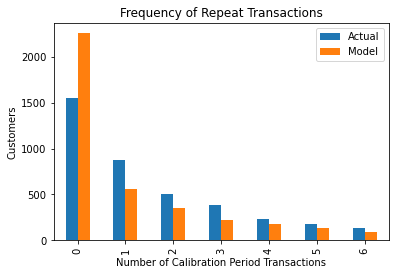

In [137]:
lifetimes_model = BetaGeoFitter(penalizer_coef=l2_bgnbd)
lifetimes_model.fit(metrics_df['frequency'], metrics_df['recency'], metrics_df['T'])


from lifetimes.plotting import plot_period_transactions
plot_period_transactions(lifetimes_model)

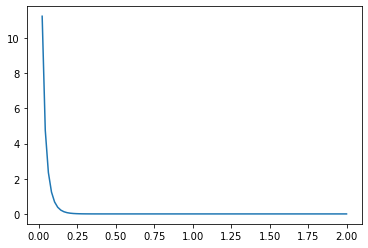

In [118]:
# 고객별 lambda (구매율) 의 분포
from scipy.stats import gamma
import matplotlib.pyplot as plt

coefs = lifetimes_model.summary['coef']
x = np.linspace (0, 2, 100) 
y = gamma.pdf(x, a=coefs['r'], scale=1/coefs['alpha'])

plt.plot(x, y)

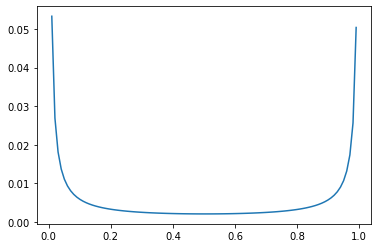

In [119]:
# 이탈률 p의 분포
from scipy.stats import beta
x = np.linspace (0, 1, 100) 
y = beta.pdf(x, a=coefs['a'], b=coefs['b'])

plt.plot(x,y)

In [120]:
spend_model = GammaGammaFitter(penalizer_coef=l2_gg)
spend_model.fit(filtered_df['frequency_cal'], filtered_df['monetary_value_cal'])
spend_model.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,3.527955,0.109036,3.314245,3.741665
q,0.323137,0.008253,0.306961,0.339314
v,3.406318,0.110571,3.189599,3.623038


In [121]:
# conditional_expected_average_profit: 고객별 평균 구매 금액 예측
monetary_actual = filtered_df['monetary_value_holdout']
monetary_predicted = spend_model.conditional_expected_average_profit(filtered_df['frequency_holdout']
                                                                    ,filtered_df['monetary_value_holdout'])

mse = score_model(monetary_actual, monetary_predicted, 'mse')

print('MSE: {0}'.format(mse))


MSE: 364.3300491426786


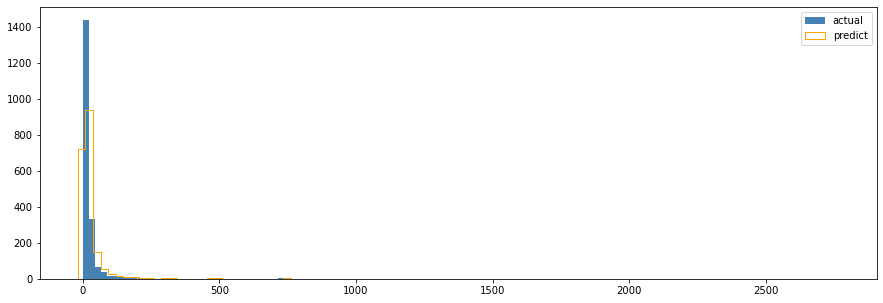

In [122]:
a

MSE: 64723.15556623815


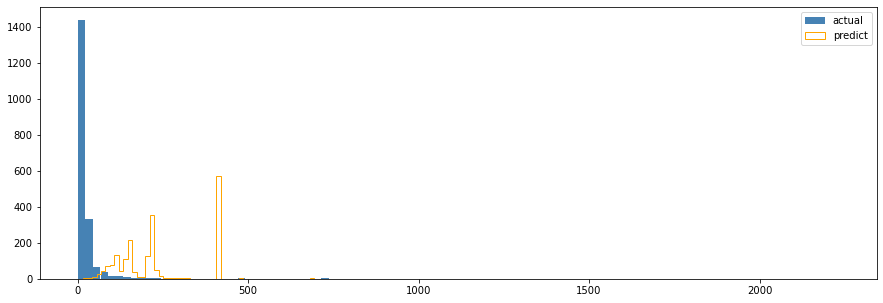

In [123]:
# penalizer_coef 없이 했을 때의 결과
spend_model = GammaGammaFitter(penalizer_coef=0)
spend_model.fit(filtered_df['frequency_cal'], filtered_df['monetary_value_cal'])

# 평가
monetary_actual = filtered_df['monetary_value_holdout']
monetary_predicted = spend_model.conditional_expected_average_profit(filtered_df['frequency_holdout']
                                                                    ,filtered_df['monetary_value_holdout'])

mse = score_model(monetary_actual, monetary_predicted, 'mse')

print('MSE: {0}'.format(mse))

import matplotlib.pyplot as plt

# define histogram bin count
bins = 100

# plot size
plt.figure(figsize=(15, 5))

# histogram plot values and presentation
plt.hist(monetary_actual, bins, label='actual', histtype='bar', color='STEELBLUE', rwidth=0.99)
plt.hist( monetary_predicted, bins, label='predict', histtype='step', color='ORANGE',  rwidth=0.99)

# place legend on chart
plt.legend(loc='upper right')

lambda ~ Gamma (alpha, r)
Geo(p)
p ~ Beta (a,b)

## Step 7. CLV 계산하기

In [153]:
# LTV 구하기
# customer_lifetime_value 함수

final_df = whole_filtered_df.copy()
final_df['ltv'] = spend_model.customer_lifetime_value(lifetimes_model,
                                                     final_df['frequency'],
                                                     final_df['recency'],
                                                     final_df['T'],
                                                     final_df['monetary_value'],
                                                     time = 12, # monthly
                                                     discount_rate=0.01 # monthly discount rate ~12.7% 연간
                                                     )

t=365
final_df['predicted_purchases'] = lifetimes_model.conditional_expected_number_of_purchases_up_to_time(t
                                                                                      , final_df['frequency']
                                                                                     , final_df['recency']
                                                                                     , final_df['T'])

final_df['predicted_monetary_value'] = spend_model.conditional_expected_average_profit(final_df['frequency']
                                                                    ,final_df['monetary_value'])


In [154]:
final_df.sort_values(by="ltv").tail(5)

,frequency,recency,T,monetary_value,ltv,predicted_purchases,predicted_monetary_value
CustomerID,,,,,,,
17450.0,26.0,359.0,367.0,7404.690385,161604.300420,24.452802,7144.098119
16446.0,1.0,205.0,205.0,168469.600000,162149.877070,2.082281,84178.331306
14096.0,16.0,97.0,101.0,4071.434375,167459.899323,46.959993,3854.836146
18102.0,25.0,367.0,367.0,9349.477200,195928.759145,23.523632,9003.615503
14646.0,44.0,353.0,354.0,6366.705909,245579.030012,42.587232,6233.543383


In [150]:
# 고객 순위 매기기
final_df.sort_values(by="ltv").tail(5)
# 14911번 고객은 3일에 한 번 꼴로 살 것이라 예상

,frequency,recency,T,monetary_value,ltv,predicted_purchases
CustomerID,,,,,,
17450.0,26.0,359.0,367.0,7404.690385,161604.300420,24.452802
16446.0,1.0,205.0,205.0,168469.600000,162149.877070,2.082281
14096.0,16.0,97.0,101.0,4071.434375,167459.899323,46.959993
18102.0,25.0,367.0,367.0,9349.477200,195928.759145,23.523632
14646.0,44.0,353.0,354.0,6366.705909,245579.030012,42.587232


In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(lifetimes_model)

In [ ]:
from lifetimes.plotting import plot_probability_alive_matrix
plot_probability_alive_matrix(lifetimes_model)

In [149]:
# 고객 순위 매기기
t=365
final_df['predicted_purchases'] = lifetimes_model.conditional_expected_number_of_purchases_up_to_time(t
                                                                                      , final_df['frequency']
                                                                                     , final_df['recency']
                                                                                     , final_df['T'])

final_df.sort_values(by="predicted_purchases").tail(5)
# 14911번 고객은 3일에 한 번 꼴로 살 것이라 예상

,frequency,recency,T,monetary_value,ltv,predicted_purchases
CustomerID,,,,,,
14606.0,88.0,372.0,373.0,135.890114,10393.000311,80.826792
15311.0,89.0,373.0,373.0,677.729438,51022.513272,81.741983
17841.0,111.0,372.0,373.0,364.452162,34386.342599,101.876193
12748.0,113.0,373.0,373.0,298.360885,28718.860152,103.706576
14911.0,131.0,372.0,373.0,1093.661679,121009.697788,120.180020
